In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import pickle
import numpy as np
import pandas as pd
import re

import lightgbm
import torch
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour

# Read the data

In [11]:
train_data = np.load("full_obs_data_train.npz")
val_data = np.load("full_obs_data_val.npz")
test_data = np.load("full_obs_data_test.npz")

dn = train_data["dn"]
senior = train_data["senior"]
topo = train_data["topo"]

dn = np.hstack([np.zeros((dn.shape[0],1)),dn])
senior = np.hstack([np.ones((senior.shape[0],1)),senior])
topo = np.hstack([2 * np.ones((topo.shape[0],1)),topo])

Xy_train = np.concatenate([dn,senior,topo],axis=0)
X_train, y_train = Xy_train[:, :-1], Xy_train[:,-1]


dn = val_data["dn"]
senior = val_data["senior"]
topo = val_data["topo"]

dn = np.hstack([np.zeros((dn.shape[0],1)),dn])
senior = np.hstack([np.ones((senior.shape[0],1)),senior])
topo = np.hstack([2 * np.ones((topo.shape[0],1)),topo])

Xy_val = np.concatenate([dn,senior,topo],axis=0)
X_val, y_val = Xy_val[:, :-1], Xy_val[:,-1]

dn = test_data["dn"]
senior = test_data["senior"]
topo = test_data["topo"]

dn = np.hstack([np.zeros((dn.shape[0],1)),dn])
senior = np.hstack([np.ones((senior.shape[0],1)),senior])
topo = np.hstack([2 * np.ones((topo.shape[0],1)),topo])

Xy_test = np.concatenate([dn,senior,topo],axis=0)
X_test, y_test = Xy_test[:, :-1], Xy_test[:,-1]

In [12]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


(152234, 4296) (152234,) (18881, 4296) (18881,) (18448, 4296) (18448,)


# Model Training

In [13]:
params = {'objective': 'multiclass', 'num_class': 4, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_threads': 100, 'feature_pre_filter': False, 'lambda_l1': 3.2098465540139256e-07, 'lambda_l2': 2.4047571314842216e-08, 'num_leaves': 62, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000}
lgb_model = lightgbm.LGBMClassifier(**params)



In [14]:
lgb_model.fit(X_train, y_train)
#alternatively load trained model
#with open('./models/lightgbm_new.pkl', 'rb') as f:
    #lgb_model = pickle.load(f)

/mnt/home/mhassouna/.conda/envs/grid/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMClassifier(bagging_fraction=1.0, bagging_freq=0,
               feature_fraction=0.8999999999999999, feature_pre_filter=False,
               lambda_l1=3.2098465540139256e-07,
               lambda_l2=2.4047571314842216e-08, metric='multi_logloss',
               num_class=4, num_iterations=1000, num_leaves=62, num_threads=100,
               objective='multiclass', verbosity=-1)

In [16]:
# save trained model
#with open('./models/lightgbm_new.pkl', 'wb') as f:
    #pickle.dump(lgb_model,f)

In [17]:
y_pred_train = lgb_model.predict(X_train)
y_pred_val = lgb_model.predict(X_val)
y_pred_test = lgb_model.predict(X_test)


print("Train Acc", accuracy_score(y_train, y_pred_train))
print("Train Balanced Acc", balanced_accuracy_score(y_train, y_pred_train))
print("Val Acc", accuracy_score(y_val, y_pred_val))
print("Val Balanced Acc", balanced_accuracy_score(y_val, y_pred_val))
print("Test Acc", accuracy_score(y_test, y_pred_test))
print("Test Balanced Acc", balanced_accuracy_score(y_test, y_pred_test))

Train Acc 0.9992117398215904
Train Balanced Acc 0.9990773866205963
Val Acc 0.8219903606800487
Val Balanced Acc 0.7599973474724457
Test Acc 0.8235039028620988
Test Balanced Acc 0.7632843753174275


In [89]:
y_val_binary = y_val.copy()
y_pred_val_binary = y_pred_val.copy()
y_val_binary[y_val_binary > 0] = 1
y_pred_val_binary[y_pred_val_binary > 0] = 1
print("Val Binary Acc", accuracy_score(y_val_binary, y_pred_val_binary))
print("Val Binary Balanced Acc", balanced_accuracy_score(y_val_binary, y_pred_val_binary))

Val Binary Acc 0.8586409618134633
Val Binary Balanced Acc 0.8609150116214783


In [90]:
dn = np.load("OOD_DoNothing_obs_data.npy")
senior = np.load("OOD_Senior_original_95_obs_data.npy")
topo = np.load("OOD_Topo_Agent_95_2_obs_data.npy")

dn = np.hstack([np.zeros((dn.shape[0],1)),dn])
senior = np.hstack([np.ones((senior.shape[0],1)),senior])
topo = np.hstack([2 * np.ones((topo.shape[0],1)),topo])


Xy_test_ood = np.concatenate([dn, senior, topo])
X_test_ood, y_test_ood = Xy_test_ood[:,:-1], Xy_test_ood[:,-1]
print(X_test_ood.shape, y_test_ood.shape)



(6036, 4296) (6036,)


In [91]:
y_pred_test_ood = lgb_model.predict(X_test_ood)

print("Test Acc OOD", accuracy_score(y_test_ood, y_pred_test_ood))
print("Test Balanced Acc OOD", balanced_accuracy_score(y_test_ood, y_pred_test_ood))

Test Acc OOD 0.8219019218025182
Test Balanced Acc OOD 0.7614241533189406


In [92]:
y_val_binary = y_test_ood.copy()
y_pred_val_binary = y_pred_test_ood.copy()
y_val_binary[y_val_binary > 0] = 1
y_pred_val_binary[y_pred_val_binary > 0] = 1
print("Test Binary Acc OOD", accuracy_score(y_val_binary, y_pred_val_binary))
print("Test Binary Balanced Acc OOD", balanced_accuracy_score(y_val_binary, y_pred_val_binary))



Test Binary Acc OOD 0.8581842279655401
Test Binary Balanced Acc OOD 0.8606628188407015


# Feature importance

In [24]:
with open("./models/lightgbm_new.pkl", 'rb') as f:
    lgb_model = pickle.load(f)


In [25]:
feature_names= np.load('dataset_colnames.npy')
feature_names = ['agent_collected'] + feature_names.tolist()


[Text(0, 0, 'timestep_overflow_141'),
 Text(0, 1, 'p_ex_17'),
 Text(0, 2, 'a_or_154'),
 Text(0, 3, 'timestep_overflow_76'),
 Text(0, 4, 'a_or_144'),
 Text(0, 5, 'timestep_overflow_36'),
 Text(0, 6, 'timestep_overflow_100'),
 Text(0, 7, 'a_or_91'),
 Text(0, 8, 'a_or_155'),
 Text(0, 9, 'time_before_cooldown_line_149'),
 Text(0, 10, 'a_ex_12'),
 Text(0, 11, 'timestep_overflow_153'),
 Text(0, 12, 'a_ex_155'),
 Text(0, 13, 'a_or_146'),
 Text(0, 14, 'timestep_overflow_99'),
 Text(0, 15, 'timestep_overflow_142'),
 Text(0, 16, 'gen_p_60'),
 Text(0, 17, 'time_before_cooldown_line_12'),
 Text(0, 18, 'time_before_cooldown_line_148'),
 Text(0, 19, 'timestep_overflow_41'),
 Text(0, 20, 'timestep_overflow_127'),
 Text(0, 21, 'a_or_41'),
 Text(0, 22, 'timestep_overflow_147'),
 Text(0, 23, 'load_v_17'),
 Text(0, 24, 'timestep_overflow_87'),
 Text(0, 25, 'timestep_overflow_146'),
 Text(0, 26, 'minute_of_hour_0'),
 Text(0, 27, 'time_before_cooldown_line_156'),
 Text(0, 28, 'timestep_overflow_74'),
 Text

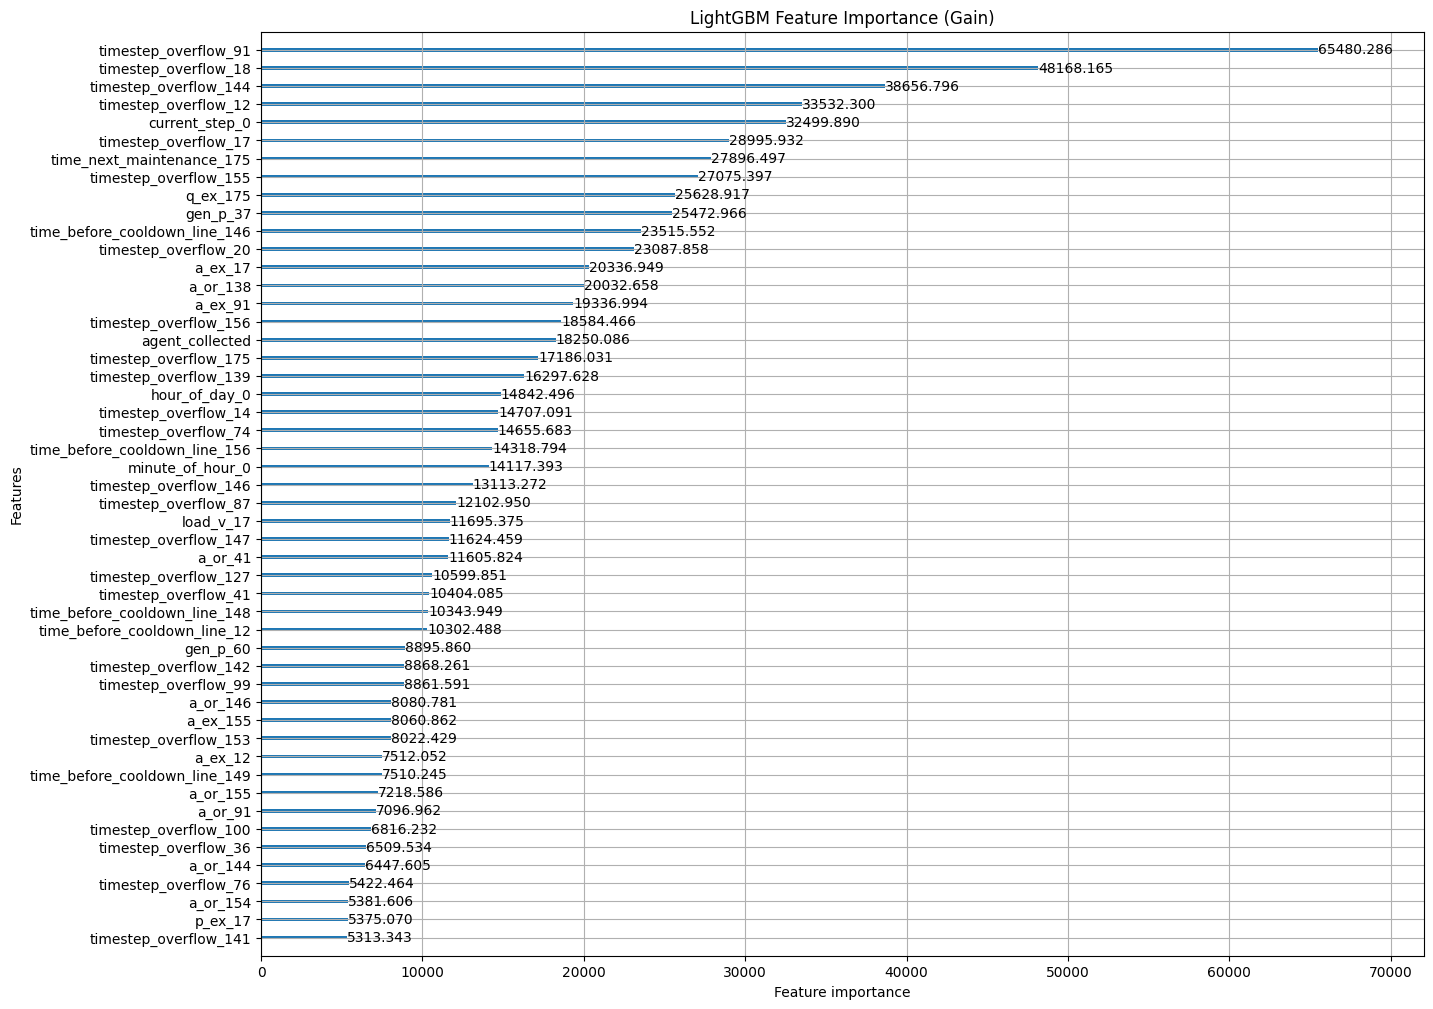

In [26]:
ax = lightgbm.plot_importance(lgb_model, importance_type="gain", max_num_features = 50, figsize=(15,12), title="LightGBM Feature Importance (Gain)")
labels = []
for x in ax.get_yticklabels():
    labels.append(feature_names[int(re.search(r'\d+', x.get_text()).group())])
ax.set_yticklabels(labels)

[Text(0, 0, 'a_or_17'),
 Text(0, 1, 'a_or_11'),
 Text(0, 2, 'timestep_overflow_156'),
 Text(0, 3, 'a_or_59'),
 Text(0, 4, 'a_or_148'),
 Text(0, 5, 'a_ex_79'),
 Text(0, 6, 'a_ex_148'),
 Text(0, 7, 'a_ex_59'),
 Text(0, 8, 'a_or_65'),
 Text(0, 9, 'a_or_181'),
 Text(0, 10, 'a_ex_166'),
 Text(0, 11, 'a_or_166'),
 Text(0, 12, 'a_ex_154'),
 Text(0, 13, 'timestep_overflow_20'),
 Text(0, 14, 'a_or_154'),
 Text(0, 15, 'a_ex_65'),
 Text(0, 16, 'time_next_maintenance_175'),
 Text(0, 17, 'timestep_overflow_12'),
 Text(0, 18, 'a_ex_91'),
 Text(0, 19, 'q_or_47'),
 Text(0, 20, 'a_or_91'),
 Text(0, 21, 'hour_of_day_0'),
 Text(0, 22, 'a_ex_6'),
 Text(0, 23, 'p_ex_72'),
 Text(0, 24, 'agent_collected'),
 Text(0, 25, 'current_step_0'),
 Text(0, 26, 'q_ex_6'),
 Text(0, 27, 'minute_of_hour_0'),
 Text(0, 28, 'p_ex_6'),
 Text(0, 29, 'gen_p_37')]

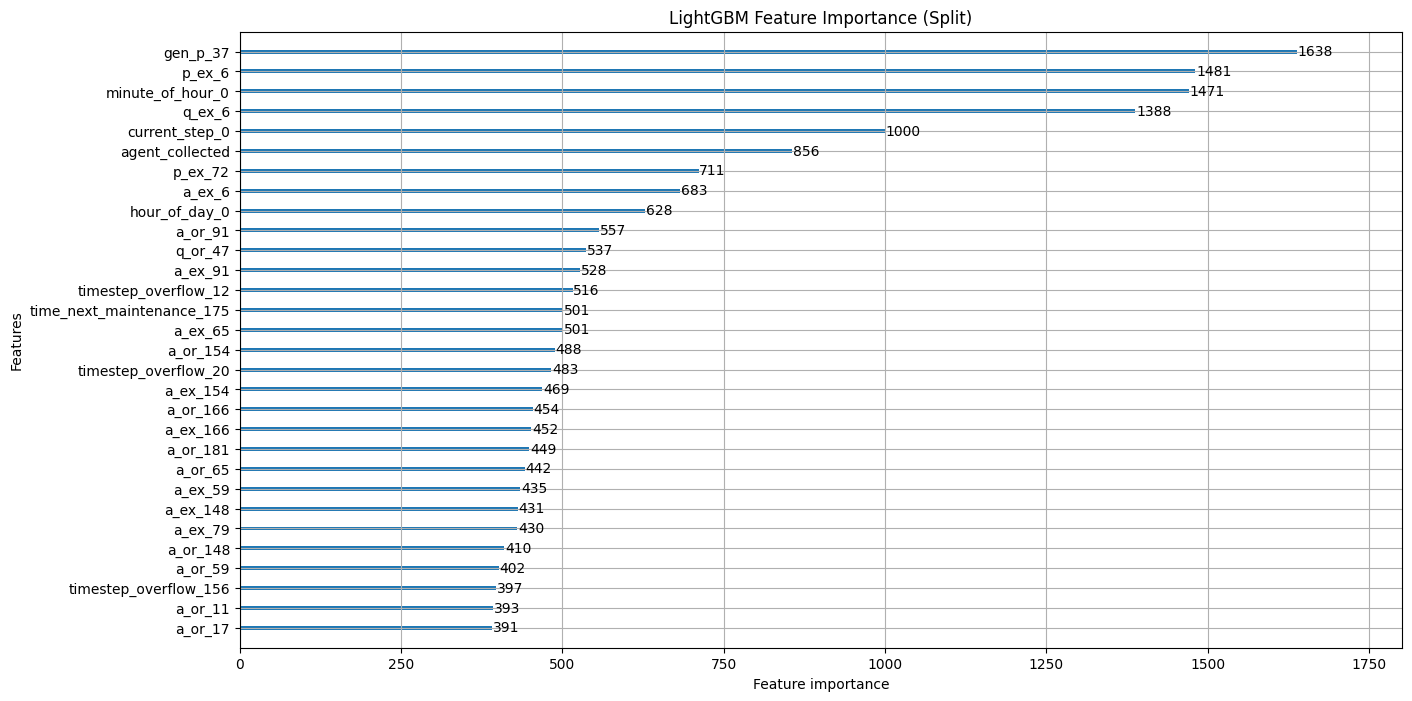

In [27]:
ax = lightgbm.plot_importance(lgb_model, importance_type="split", max_num_features = 30, figsize=(15,8), title="LightGBM Feature Importance (Split)")
labels = []
for x in ax.get_yticklabels():
    labels.append(feature_names[int(re.search(r'\d+', x.get_text()).group())])
ax.set_yticklabels(labels)

In [28]:
# Obtain gain feature importance
feature_importance = lgb_model.booster_ .feature_importance("gain")

# Display feature importance with feature names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'importance': feature_importance})
#print(feature_importance_df.sort_values(by='importance', ascending=False))

In [29]:
feature_importance_df.to_csv(path_or_buf="importance_gain.csv")
#feature_importance_df.sort_values(by=['importance'], ascending=True)[-30:]

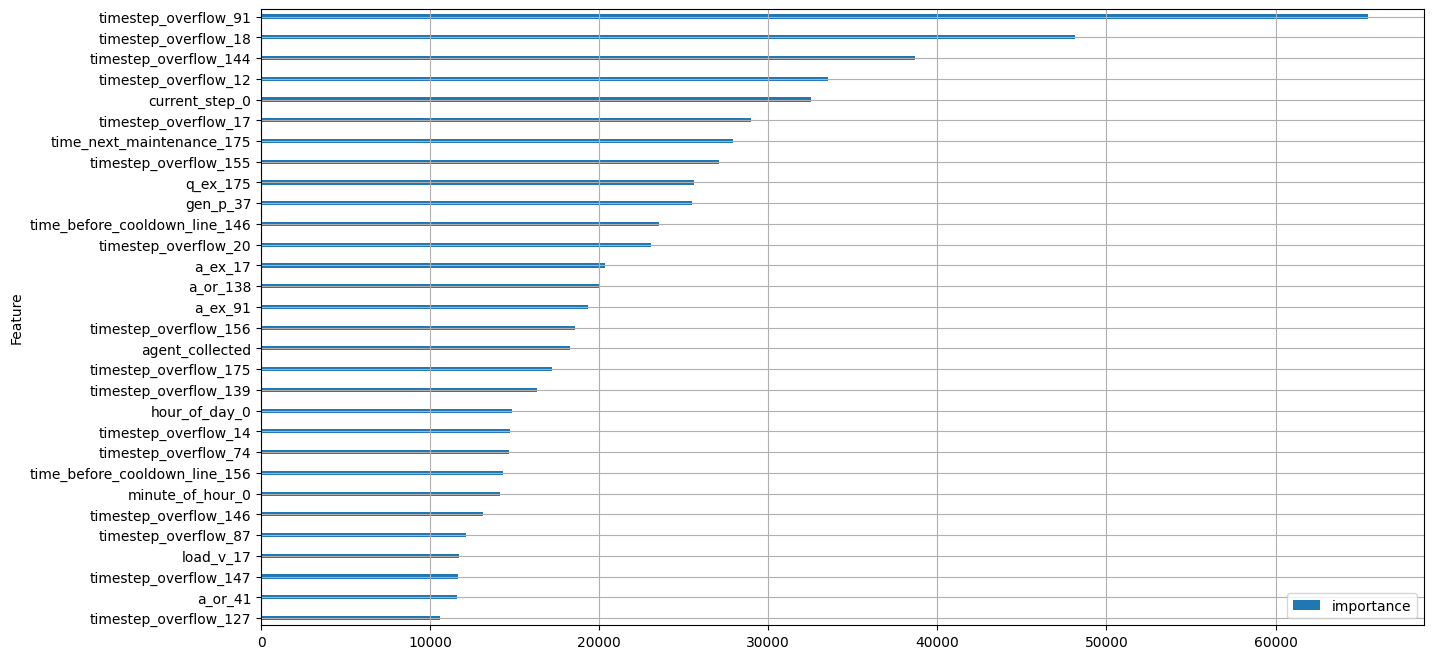

In [31]:
ax = feature_importance_df.sort_values(by=['importance'], ascending=True)[-30:].plot.barh(x="Feature", figsize=(15,8),width=0.20)
ax.grid(True)

### Aggregated features

In [33]:
feature_names_mod = []
for x in feature_names:
    if 'topo_vect' in x:
        feature_names_mod.append('topo_vect')
    else:
        feature_names_mod.append(x)

In [34]:
for i in range(186):
    feature_names_mod = [w.replace(f'a_ex_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'p_ex_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'q_ex_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'v_ex_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'theta_ex_{i}', f'line_{i}') for w in feature_names_mod]
    
    feature_names_mod = [w.replace(f'a_or_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'p_or_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'q_or_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'v_or_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'theta_or_{i}', f'line_{i}') for w in feature_names_mod]

    feature_names_mod = [w.replace(f'rho_{i}', f'line_{i}') for w in feature_names_mod]

    feature_names_mod = [w.replace(f'line_status_{i}', f'line_{i}') for w in feature_names_mod]
    
    feature_names_mod = [w.replace(f'timestep_overflow_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'time_before_cooldown_line_{i}', f'line_{i}') for w in feature_names_mod]

    feature_names_mod = [w.replace(f'time_next_maintenance_{i}', f'line_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'duration_next_maintenance_{i}', f'line_{i}') for w in feature_names_mod]

In [35]:
for i in range(62):
    feature_names_mod = [w.replace(f'gen_p_{i}', f'gen_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'gen_q_{i}', f'gen_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'gen_v_{i}', f'gen_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'gen_theta_{i}', f'gen_{i}') for w in feature_names_mod]
    

    
    feature_names_mod = [w.replace(f'actual_dispatch_{i}', f'gen_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'target_dispatch_{i}', f'gen_{i}') for w in feature_names_mod]
    
    feature_names_mod = [w.replace(f'gen_p_before_curtail_{i}', f'gen_{i}') for w in feature_names_mod]

    feature_names_mod = [w.replace(f'curtailment_mw_{i}', f'gen_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'curtailment_{i}', f'gen_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'curtailment_limit_{i}', f'gen_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'curtailment_limit_effective_{i}', f'gen_{i}') for w in feature_names_mod]
    
    feature_names_mod = [w.replace(f'gen_margin_up_{i}', f'gen_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'gen_margin_down_{i}', f'gen_{i}') for w in feature_names_mod]

In [36]:
for i in range(91):
    feature_names_mod = [w.replace(f'load_p_{i}', f'load_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'load_q_{i}', f'load_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'load_v_{i}', f'load_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'load_theta_{i}', f'load_{i}') for w in feature_names_mod]


In [37]:
for i in range(7):
    feature_names_mod = [w.replace(f'storage_charge_{i}', f'storage_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'storage_power_{i}', f'storage_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'storage_power_target_{i}', f'storage_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'storage_theta_{i}', f'storage_{i}') for w in feature_names_mod]


In [38]:
for i in range(14):
    feature_names_mod = [w.replace(f'_shunt_bus_{i}', f'shunt_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'_shunt_p_{i}', f'shunt_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'_shunt_q_{i}', f'shunt_{i}') for w in feature_names_mod]
    feature_names_mod = [w.replace(f'_shunt_v_{i}', f'shunt_{i}') for w in feature_names_mod]


In [39]:
# Obtain gain feature importancewords = [w.replace('[br]', '<br />') for w in words]
feature_importance = lgb_model.booster_ .feature_importance("gain")

# Display feature importance with feature names
feature_importance_df_mod = pd.DataFrame({'Feature': feature_names_mod, 'importance': feature_importance})
feature_importance_df_mod = feature_importance_df_mod.groupby('Feature')['importance'].mean().reset_index()

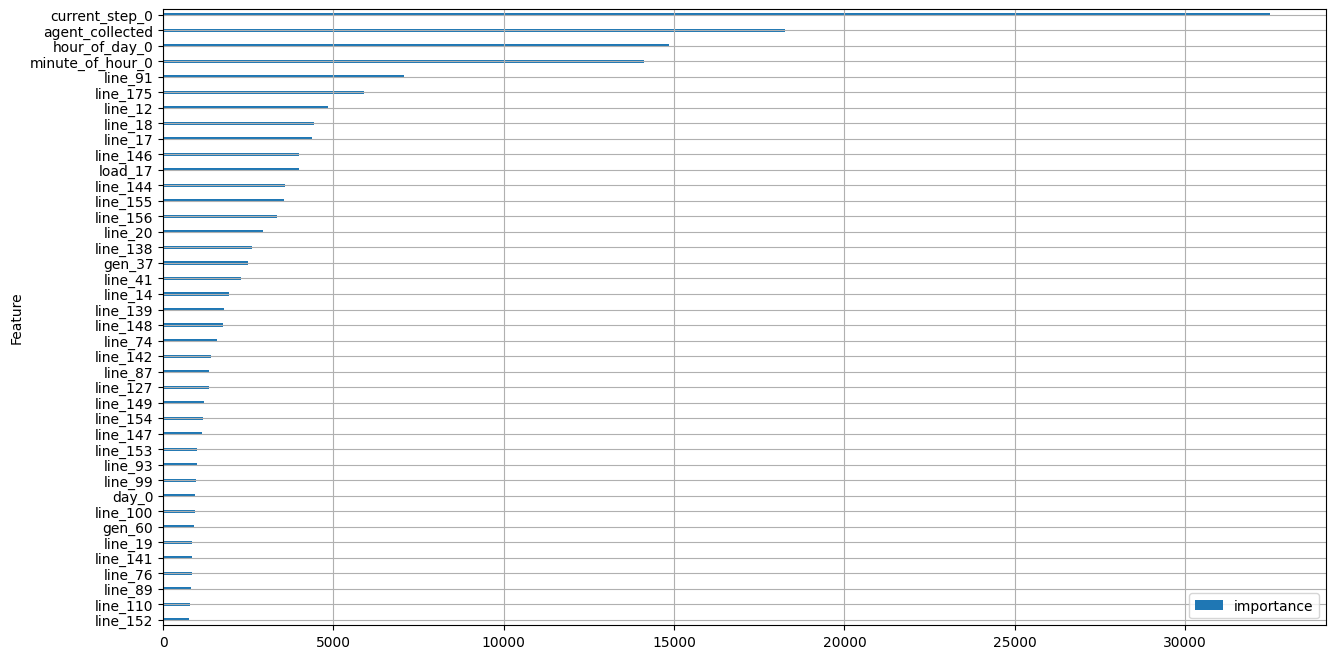

In [41]:
ax = feature_importance_df_mod.sort_values(by=['importance'], ascending=True)[-40:].plot.barh(x="Feature", figsize=(15,8),width=0.20)
ax.grid(True)

In [31]:
#plotly: height 500, width = 1000

In [42]:
import grid2op
from grid2op.PlotGrid import PlotMatplot
env_name  = "l2rpn_wcci_2022"
env = grid2op.make(env_name)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [44]:
feature_importance_df_mod_copy = feature_importance_df_mod.copy()

In [45]:
feature_importance_df_mod_copy = feature_importance_df_mod_copy[~feature_importance_df_mod_copy['Feature'].astype(str).str.startswith('line_')]
feature_importance_df_mod_copy = feature_importance_df_mod_copy[~feature_importance_df_mod_copy['Feature'].astype(str).str.startswith('load_')]
feature_importance_df_mod_copy = feature_importance_df_mod_copy[~feature_importance_df_mod_copy['Feature'].astype(str).str.startswith('gen')]

In [46]:
line_imp = feature_importance_df_mod[feature_importance_df_mod.Feature.str.startswith("line_")].sort_values(by=['importance'], ascending=False)
gen_imp = feature_importance_df_mod[feature_importance_df_mod.Feature.str.startswith("gen_")].sort_values(by=['importance'], ascending=False)
load_imp = feature_importance_df_mod[feature_importance_df_mod.Feature.str.startswith("load_")].sort_values(by=['importance'], ascending=False)

In [47]:
feature_importance_df_mod_copy = pd.concat([feature_importance_df_mod_copy,line_imp[0:10],load_imp[0:10], gen_imp[0:10]])

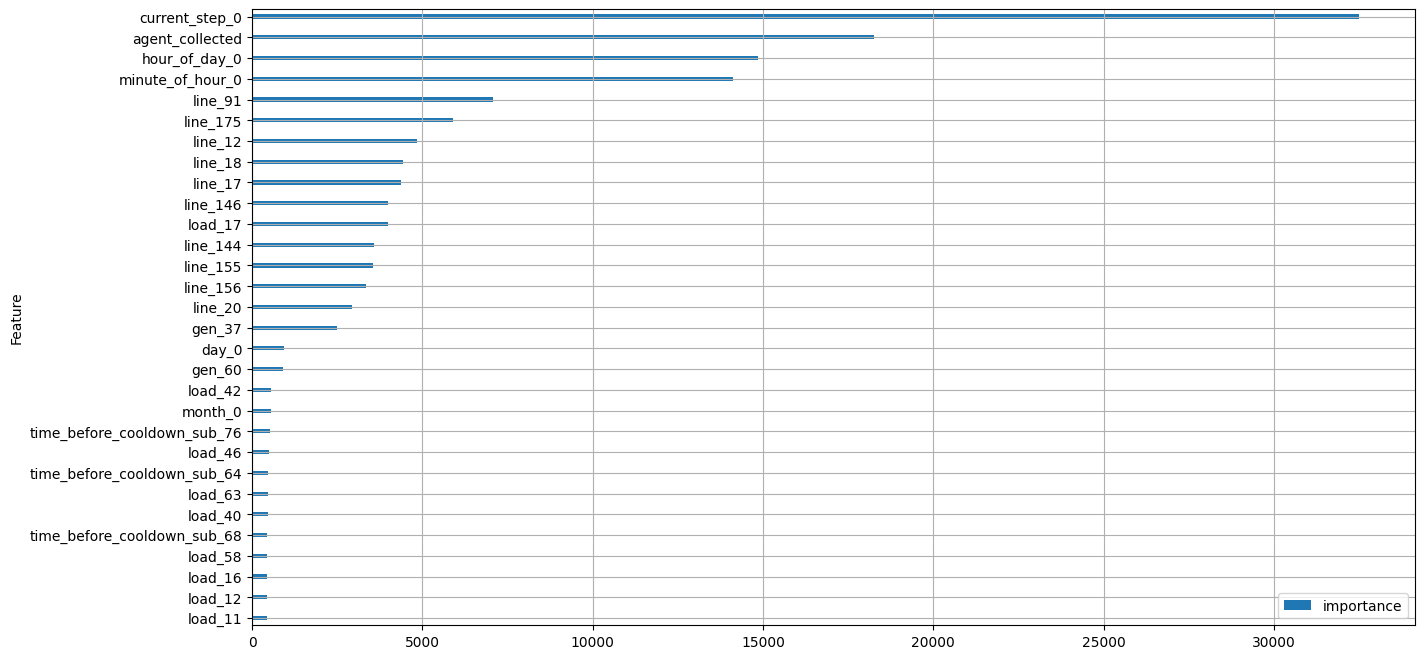

In [48]:
ax = feature_importance_df_mod_copy.sort_values(by=['importance'], ascending=True)[-30:].plot.barh(x="Feature", figsize=(15,8),width=0.20)
ax.grid(True)

## Plot of feature importance on power grid

In [49]:
from grid2op.dtypes import dt_float, dt_int
from grid2op.PlotGrid.PlotUtil import PlotUtil as pltu

In [50]:
line_imp['Feature'].str.extract(r'_(\d+)').astype(int).values.squeeze()[0:10]

array([ 91, 175,  12,  18,  17, 146, 144, 155, 156,  20])

In [51]:
gen_imp['Feature'].str.extract(r'_(\d+)').astype(int).values.squeeze()[0:10]

array([37, 60, 32, 43, 53, 45, 42, 16, 30, 17])

In [52]:
load_imp['Feature'].str.extract(r'_(\d+)').astype(int).values.squeeze()[0:10]

array([17, 42, 46, 63, 40, 58, 16, 12, 11, 30])

In [53]:
plot_helper.legend = None

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



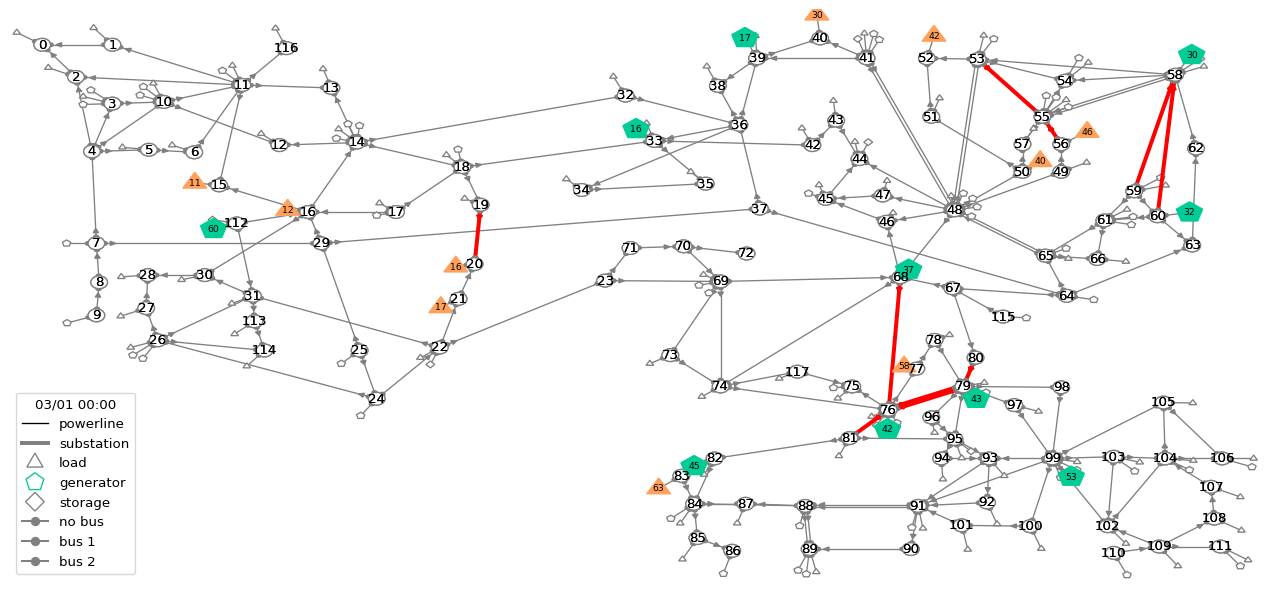

In [54]:
line_values=None

plot_helper = PlotMatplot(env.observation_space, width=1280,height=600, dpi=96)
obs=env.reset()
#sub
plot_helper._sub_edge_color = "grey"
plot_helper._line_bus_face_colors = ['grey', 'grey', 'grey']

#load
plot_helper._load_edge_color = "grey"
plot_helper._load_line_color = "grey"

#gen
plot_helper._gen_edge_color = ['grey', '#00CC96', '#00CC96']
plot_helper._gen_line_color = "grey"
for i in range(len(obs.prod_p)):
    obs.prod_p[i]=0
obs.prod_p[gen_imp['Feature'].str.extract(r'_(\d+)').astype(int).values.squeeze()[0:10]] = 1000

#storage
plot_helper._storage_edge_color = "grey"
plot_helper._storage_line_color = "grey"

#line
plot_helper._line_color_scheme = ['grey', 'grey', 'red']
obs.rho =np.ones(obs.rho.shape)*0.01
obs.rho[line_imp['Feature'].str.extract(r'_(\d+)').astype(int).values.squeeze()[0:10]] = 150

#plot_helper.assign_line_palette(palette_name="YlOrRd", nb_color=10, line_color_scheme=None)
#plot_helper.restore_line_palette()
plot_helper._line_color_width = 1
plot_helper._display_load_name = False
plot_helper._display_gen_name = False

fig = plot_helper.plot_obs(obs,line_info = None, storage_info=None,gen_info=None,load_info=None)
#sub_x = plot_helper._grid_layout["sub_21"][0]
#sub_y = plot_helper._grid_layout["sub_21"][1]

plot_helper._line_color_width = 3
redraw = True
draw_fn = plot_helper.draw_powerline
if not redraw:
    draw_fn = plot_helper.update_powerline

topo = obs.topo_vect
line_or_pos = obs.line_or_pos_topo_vect
line_ex_pos = obs.line_ex_pos_topo_vect
#plot_helper._line_name = True
for line_idx in line_imp['Feature'].str.extract(r'_(\d+)').astype(int).values.squeeze()[0:10]:
    line_or_sub = obs.line_or_to_subid[line_idx]
    line_or_sub_name = obs.name_sub[line_or_sub]
    line_ex_sub = obs.line_ex_to_subid[line_idx]
    line_ex_sub_name = obs.name_sub[line_ex_sub]
    line_name = None#obs.name_line[line_idx]
    line_status = True
    line_status = obs.line_status[line_idx]
    line_value = None#line_idx
    if line_values is not None:
        lv = line_values[line_idx]
        if isinstance(lv, (float, dt_float)):
            line_value = np.round(float(lv), 2)
        elif isinstance(lv, (int, dt_int)):
            line_value = int(lv)
        else:
            line_value = lv

    line_or_bus = topo[line_or_pos[line_idx]]
    line_or_bus = line_or_bus if line_or_bus > 0 else 0
    line_or_x = plot_helper._grid_layout[line_or_sub_name][0]
    line_or_y = plot_helper._grid_layout[line_or_sub_name][1]
    line_ex_bus = topo[line_ex_pos[line_idx]]
    line_ex_bus = line_ex_bus if line_ex_bus > 0 else 0
    line_ex_x = plot_helper._grid_layout[line_ex_sub_name][0]
    line_ex_y = plot_helper._grid_layout[line_ex_sub_name][1]

    # Special case for parralel lines
    tmp = plot_helper.observation_space.get_lines_id(
        from_=line_or_sub, to_=line_ex_sub
    )
    if len(tmp) > 1:
        ox, oy = pltu.orth_norm_from_points(
            line_or_x, line_or_y, line_ex_x, line_ex_y
        )
        if line_idx == tmp[0]:
            line_or_x += ox * plot_helper._parallel_spacing
            line_or_y += oy * plot_helper._parallel_spacing
            line_ex_x += ox * plot_helper._parallel_spacing
            line_ex_y += oy * plot_helper._parallel_spacing
        else:
            line_or_x -= ox * plot_helper._parallel_spacing
            line_or_y -= oy * plot_helper._parallel_spacing
            line_ex_x -= ox * plot_helper._parallel_spacing
            line_ex_y -= oy * plot_helper._parallel_spacing

    draw_fn(
        plot_helper.figure,
        obs,
        line_idx,
        line_name,
        line_status,
        line_value,
        "",
        line_or_bus,
        line_or_x,
        line_or_y,
        line_ex_bus,
        line_ex_x,
        line_ex_y,
    )

plot_helper._plot_subs(plot_helper.figure, obs, True)


# loads
keys_loads = [key for key in plot_helper._grid_layout if key.startswith("load_")]


for l_id in load_imp['Feature'].str.extract(r'_(\d+)').astype(int).values.squeeze()[0:10]:
    mat = obs.connectivity_matrix(as_csr_matrix=False)
    which_connected = mat[obs.load_pos_topo_vect[l_id]] == 1
    sub_id = obs.grid_objects_types[which_connected,][0][0]
    
    pos_x = plot_helper._grid_layout[f"{keys_loads[l_id]}"][0]
    pos_y = plot_helper._grid_layout[f"{keys_loads[l_id]}"][1]
    sub_x = plot_helper._grid_layout[f"sub_{sub_id}"][0]
    sub_y = plot_helper._grid_layout[f"sub_{sub_id}"][1]
    plot_helper._load_face_color = "#FFA15A"
    plot_helper._load_edge_color = "#FFA15A"
    plot_helper._load_radius = 25
    plot_helper._display_load_name = False

    plot_helper._draw_load_circle(pos_x, pos_y)
    plot_helper._draw_load_name(pos_x, pos_y, str(l_id))


# gens
keys_gens = [key for key in plot_helper._grid_layout if key.startswith("gen_")]


for gen_id in gen_imp['Feature'].str.extract(r'_(\d+)').astype(int).values.squeeze()[0:10]:
    mat = obs.connectivity_matrix(as_csr_matrix=False)
    which_connected = mat[obs.gen_pos_topo_vect[gen_id]] == 1
    sub_id = obs.grid_objects_types[which_connected,][0][0]
    
    pos_x = plot_helper._grid_layout[f"{keys_gens[gen_id]}"][0]
    pos_y = plot_helper._grid_layout[f"{keys_gens[gen_id]}"][1]
    #sub_x = plot_helper._grid_layout[f"sub_{sub_id}"][0]
    #sub_y = plot_helper._grid_layout[f"sub_{sub_id}"][1]
    plot_helper._gen_edge_color = "#00CC96"
    plot_helper._gen_radius = 25
    plot_helper._gen_face_color = "#00CC96"

    plot_helper._draw_gen_circle(pos_x, pos_y, plot_helper._gen_edge_color)
    plot_helper._draw_gen_name(pos_x, pos_y, str(gen_id))


In [55]:
for ax in fig.axes:
    ax.get_legend().remove()

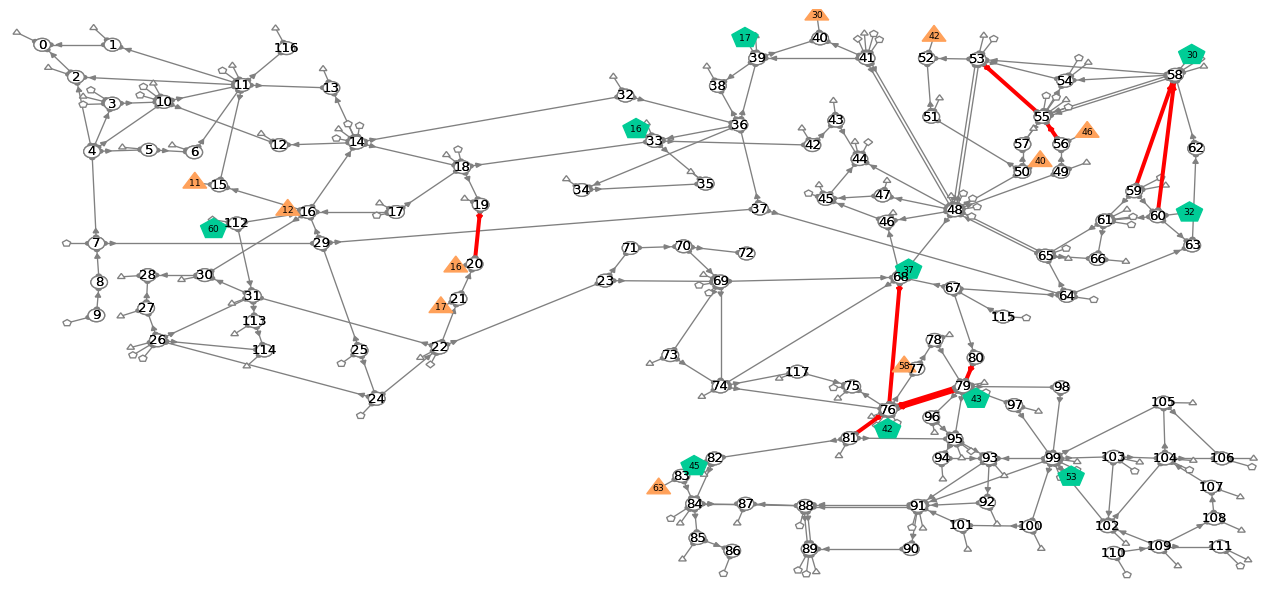

In [56]:
plot_helper.figure

In [57]:
fig.savefig("grid_importance.svg")

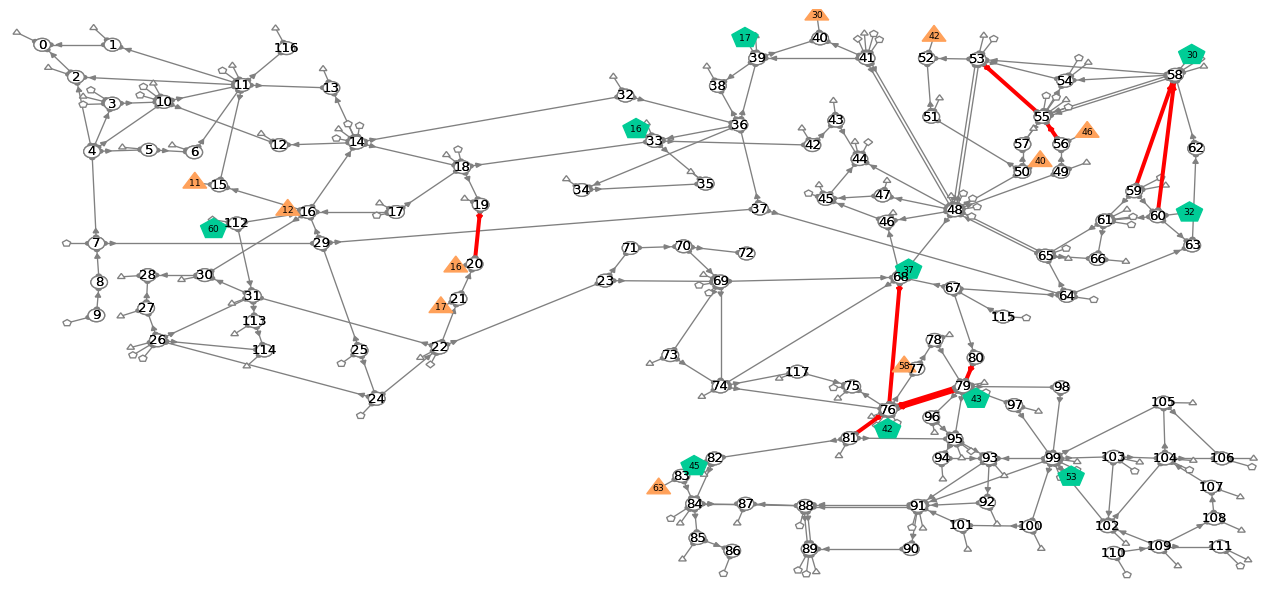

In [58]:
fig

## Confusion matrices

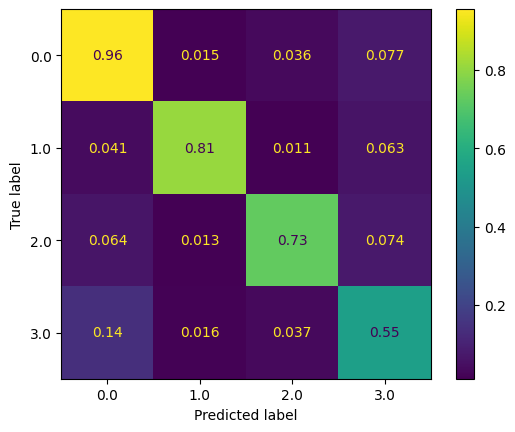

In [128]:
#ConfusionMatrixDisplay.from_estimator(hgb2, X_val, y_val)

cm = confusion_matrix(y_val, y_pred_val, labels=lgb_model.classes_)
cm = cm / cm.sum(axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_model.classes_)

disp.plot()
plt.show()

In [129]:
y_val_binary = y_val.copy()
y_pred_val_binary = y_pred_val.copy()
y_val_binary[y_val_binary > 0] = 1
y_pred_val_binary[y_pred_val_binary > 0] = 1
print("Val Acc", accuracy_score(y_val_binary, y_pred_val_binary))
print("Val Balanced Acc", balanced_accuracy_score(y_val_binary, y_pred_val_binary))

Val Acc 0.8586409618134633
Val Balanced Acc 0.8609150116214783


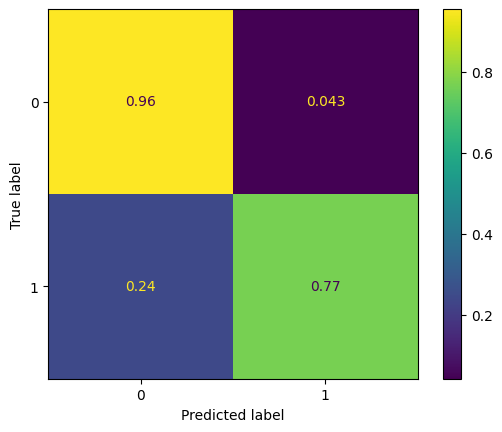

In [130]:
cm2 = confusion_matrix(y_val_binary, y_pred_val_binary)
cm2 = cm2 / cm2.sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)

disp.plot()
plt.show()

In [131]:
y_val_only_negative = y_val.copy()
y_pred_val_only_negative = y_pred_val.copy()

y_pred_val_only_negative = y_pred_val_only_negative[y_val_only_negative > 0]
y_val_only_negative = y_val_only_negative[y_val_only_negative > 0]
print("Val Acc", accuracy_score(y_val_only_negative, y_pred_val_only_negative))
print("Val Balanced Acc", balanced_accuracy_score(y_val_only_negative, y_pred_val_only_negative))

Val Acc 0.6949731071576334
Val Balanced Acc 0.6949029360343922


/mnt/home/mhassouna/.conda/envs/grid/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


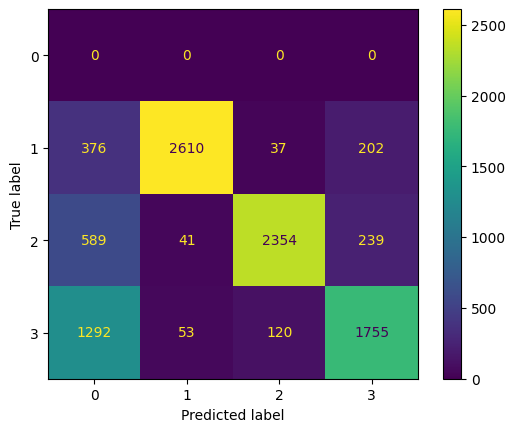

In [132]:
cm3 = confusion_matrix(y_val_only_negative, y_pred_val_only_negative)
#cm3 = cm3 / cm3.sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3)

disp.plot()
plt.show()

## Plot distributions of output

In [133]:
y_pred_val_prob = lgb_model.predict_proba(X_val)[:, [0, 3, 2, 1]]

In [134]:
#plt.bar(x=np.arange(4),height=y_pred_val_prob[np.where(y_val==0)[0]].mean(axis=0))

In [135]:
y_val_flipped = y_val.copy()
y_val_flipped[y_val_flipped == 1], y_val_flipped[y_val_flipped == 3] = 3, 1
y_pred_val_prob_0 = y_pred_val_prob[np.where(y_val==0)[0]].mean(axis=0)
y_pred_val_prob_1 = y_pred_val_prob[np.where(y_val==1)[0]].mean(axis=0)
y_pred_val_prob_2 = y_pred_val_prob[np.where(y_val==2)[0]].mean(axis=0)
y_pred_val_prob_3 = y_pred_val_prob[np.where(y_val==3)[0]].mean(axis=0)

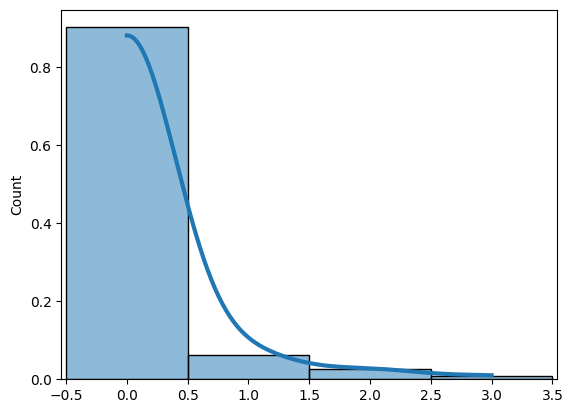

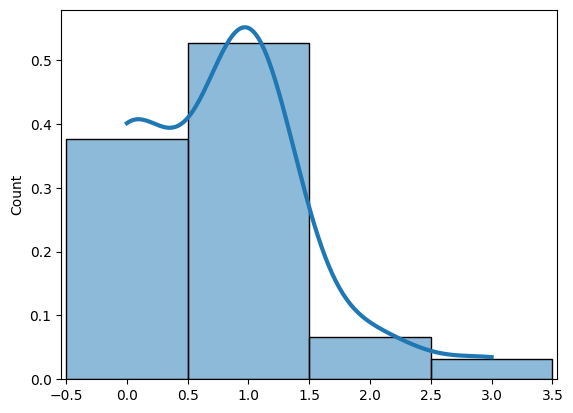

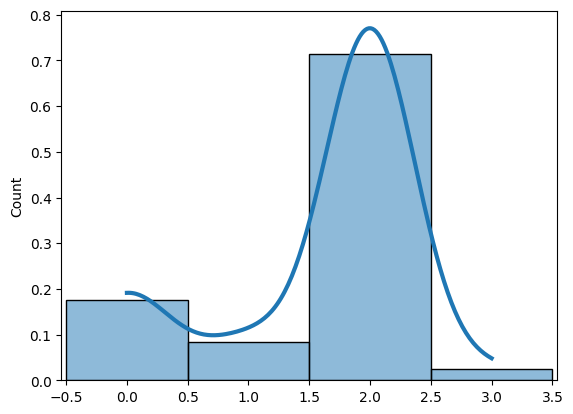

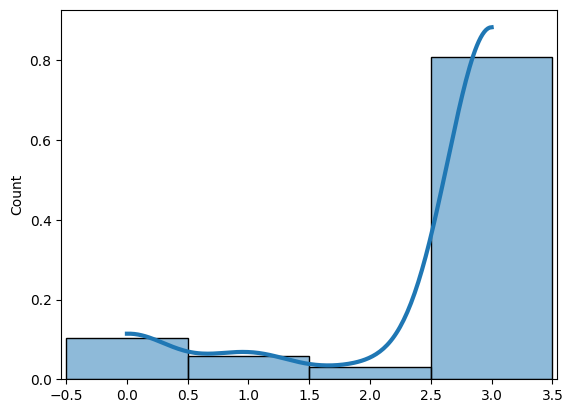

In [136]:
import seaborn as sns

ax = sns.histplot(x=np.arange(4), weights=y_pred_val_prob_0, discrete=True,
                  kde=True, kde_kws={'bw_adjust': 0.38}, line_kws={'linewidth': 3})
ax.margins(x=0.01)
plt.show()

ax = sns.histplot(x=np.arange(4), weights=y_pred_val_prob_3, discrete=True,
                  kde=True, kde_kws={'bw_adjust': 0.5}, line_kws={'linewidth': 3})
ax.margins(x=0.01)
plt.show()

ax = sns.histplot(x=np.arange(4), weights=y_pred_val_prob_2, discrete=True,
                  kde=True, kde_kws={'bw_adjust': 0.35}, line_kws={'linewidth': 3})
ax.margins(x=0.01)
plt.show()


ax = sns.histplot(x=np.arange(4), weights=y_pred_val_prob_1, discrete=True,
                  kde=True, kde_kws={'bw_adjust': 0.23}, line_kws={'linewidth': 3})
ax.margins(x=0.01)
plt.show()